In [1]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'SR'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/SR


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.init as init
from math import log10
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
from os import listdir
from os.path import join
from scipy.io import loadmat
from tqdm import tqdm

In [3]:
#Model

class subpixelCNN(nn.Module):
    def __init__(self, upscale_factor=4, width=1):
        super(subpixelCNN, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 128*width, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(128*width, 128*width, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(128*width, 64*width, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(64*width, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

In [8]:
# Parameters
BATCH_SIZE = 16
NUM_WORKERS = 0 # on Windows, set this variable to 0
scale_factor = 4
nb_epochs = 650
cuda = True
CROP_SIZE = 128

device = torch.device("cuda:0" if (torch.cuda.is_available() and cuda) else "cpu")
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [5]:
class DatasetFromTensor(Dataset):
    def __init__(self, data, scale_factor, with_bicubic_upsampling = True):
        super(DatasetFromTensor, self).__init__()
        self.data = data

        crop_size = CROP_SIZE - (CROP_SIZE % scale_factor) # Valid crop size
        
        if with_bicubic_upsampling:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor),  # subsampling the image (half size)
                                        transforms.Resize(crop_size, interpolation=Image.BICUBIC)  # bicubic upsampling to get back the original size 
                                        ])
        else:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor)  # subsampling the image (half size)
                                        ])
                
        self.target_transform = transforms.Compose([transforms.CenterCrop(crop_size) # since it's the target, we keep its original quality
                                        ])

    def __getitem__(self, index):
        input = self.data[index]
        target = input.clone()

        GB = transforms.GaussianBlur(kernel_size=(3,3), sigma=(1,1))
        
        input = GB(input)
        input = self.input_transform(input)
        target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.data)


In [6]:
data = loadmat('ns_data_Ve5_SRCNN.mat')
w = torch.from_numpy(data['w'])[:256]
w = w.reshape(shape=(w.shape[0], 1, w.shape[1], w.shape[2]))

In [7]:
trainset = DatasetFromTensor(w[:200], scale_factor=scale_factor, with_bicubic_upsampling=False)
testset = DatasetFromTensor(w[200:], scale_factor=scale_factor, with_bicubic_upsampling=False)

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [9]:
model = subpixelCNN().to(device)
model = model.float()

criterion = nn.MSELoss()

optimizer = optim.Adam(  # we use Adam instead of SGD like in the paper, because it's faster
    [
        {"params": model.conv1.parameters(), "lr": 0.0001},  
        {"params": model.conv2.parameters(), "lr": 0.0001},
        {"params": model.conv3.parameters(), "lr": 0.00001},
    ], lr=0.00001,
)


hist_loss_train = []
hist_loss_test = []
hist_psnr_train = []
hist_psnr_test = []


for epoch in range(nb_epochs):

    # Train
    avg_psnr = 0
    epoch_loss = 0
    for iteration, batch in enumerate(tqdm(trainloader)):
      input, target = batch[0].to(device), batch[1].to(device)
      input, target = input.float(), target.float()
      optimizer.zero_grad()

      out = model(input)
      loss = criterion(out, target)
      psnr = 10 * log10(1 / loss.item())
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      avg_psnr += psnr

    print(f"Epoch {epoch}. Training loss: {epoch_loss / len(trainloader)}")
    hist_loss_train.append(epoch_loss / len(trainloader))
    hist_psnr_train.append(avg_psnr / len(trainloader))

    # Test
    avg_psnr = 0
    epoch_loss = 0
    with torch.no_grad():
        for batch in testloader:
            input, target = batch[0].to(device), batch[1].to(device)
            input, target = input.float(), target.float()

            out = model(input)
            loss = criterion(out, target)
            psnr = 10 * log10(1 / loss.item())
            epoch_loss += loss.item()
            avg_psnr += psnr

    print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")
    hist_loss_test.append(epoch_loss / len(testloader))
    hist_psnr_test.append(avg_psnr / len(testloader))

#torch.save(model, f"model_{epoch}.pth")

100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 0. Training loss: 0.11865213513374329
Average PSNR: 11.192690698678298 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 1. Training loss: 0.06399790312235172
Average PSNR: 13.366180804725365 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 2. Training loss: 0.039615074602457195
Average PSNR: 15.190459422612038 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 3. Training loss: 0.027339723534308948
Average PSNR: 16.55454644362625 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 4. Training loss: 0.021178563913473718
Average PSNR: 17.42024205253311 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 5. Training loss: 0.017753925174474716
Average PSNR: 18.07283790876124 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 6. Training loss: 0.015364046280200664
Average PSNR: 18.6122278470649 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 7. Training loss: 0.01380807626992464
Average PSNR: 19.0690193062736 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 8. Training loss: 0.012356417396893868
Average PSNR: 19.474431207604795 dB.


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 9. Training loss: 0.011437476935008397
Average PSNR: 19.827064163021895 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 10. Training loss: 0.010511965849078618
Average PSNR: 20.161224484018838 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 11. Training loss: 0.009697168420713682
Average PSNR: 20.484020028705356 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 12. Training loss: 0.009297715965658426
Average PSNR: 20.763849526253253 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 13. Training loss: 0.008512784547817249
Average PSNR: 21.034519337245985 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 14. Training loss: 0.00805142496784146
Average PSNR: 21.315481696538527 dB.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 15. Training loss: 0.007454282317597132
Average PSNR: 21.59458798532675 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 16. Training loss: 0.0070544045705061694
Average PSNR: 21.909138102811728 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 17. Training loss: 0.00644238106906414
Average PSNR: 22.380655342189556 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 18. Training loss: 0.005770879081235482
Average PSNR: 22.804901051799533 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 19. Training loss: 0.00532593998986368
Average PSNR: 23.153222866551694 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 20. Training loss: 0.004970406970152488
Average PSNR: 23.44058732662844 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 21. Training loss: 0.004652803333906027
Average PSNR: 23.692223093174672 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 22. Training loss: 0.004368241983824051
Average PSNR: 23.922115620159556 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 23. Training loss: 0.0041828435093451
Average PSNR: 24.130500128405384 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 24. Training loss: 0.003983873103816922
Average PSNR: 24.325930413573708 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 25. Training loss: 0.0037686015443446543
Average PSNR: 24.51592337763315 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 26. Training loss: 0.003609889831680518
Average PSNR: 24.690641046631292 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 27. Training loss: 0.003490892991137046
Average PSNR: 24.86074238551369 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 28. Training loss: 0.00337875634431839
Average PSNR: 25.0317704832855 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 29. Training loss: 0.0032860049977898598
Average PSNR: 25.196944235784493 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 30. Training loss: 0.0031219573619847116
Average PSNR: 25.357428609199157 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 31. Training loss: 0.003013947047293186
Average PSNR: 25.513779485665868 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 32. Training loss: 0.0028825945471628355
Average PSNR: 25.66050843867557 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 33. Training loss: 0.0028040937076394376
Average PSNR: 25.80027217430325 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 34. Training loss: 0.002745877431992155
Average PSNR: 25.937403149375996 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 35. Training loss: 0.0026202293721815715
Average PSNR: 26.0736169810026 dB.


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 36. Training loss: 0.002576386135143156
Average PSNR: 26.210233973166687 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 37. Training loss: 0.0024772115553227756
Average PSNR: 26.3421925429336 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 38. Training loss: 0.0024117579540381064
Average PSNR: 26.474450004535207 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 39. Training loss: 0.0023367020946282605
Average PSNR: 26.59921227805662 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 40. Training loss: 0.002256723756615359
Average PSNR: 26.725229434093485 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 41. Training loss: 0.0022072296303052167
Average PSNR: 26.851307261598073 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 42. Training loss: 0.0021545169695925256
Average PSNR: 26.976802491713396 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 43. Training loss: 0.0020689335383044984
Average PSNR: 27.09926917333731 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 44. Training loss: 0.002009803599391419
Average PSNR: 27.22104728237709 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 45. Training loss: 0.0019642959724968444
Average PSNR: 27.343730506627857 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 46. Training loss: 0.0019145253060672146
Average PSNR: 27.462352379606248 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 47. Training loss: 0.001850697946233245
Average PSNR: 27.57389229575498 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 48. Training loss: 0.0018167751303945596
Average PSNR: 27.68807471625096 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 49. Training loss: 0.0017562834098218726
Average PSNR: 27.80403679213748 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 50. Training loss: 0.0017175237791469465
Average PSNR: 27.911220857727255 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 51. Training loss: 0.001659669832756313
Average PSNR: 28.01681213849912 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 52. Training loss: 0.001632802546597444
Average PSNR: 28.122134581716885 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 53. Training loss: 0.0016066571249841498
Average PSNR: 28.22946308582418 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 54. Training loss: 0.0015346794120537548
Average PSNR: 28.332504057072864 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 55. Training loss: 0.0015213751287844318
Average PSNR: 28.43209925302193 dB.


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Epoch 56. Training loss: 0.0015065902217219656
Average PSNR: 28.530502717619537 dB.


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch 57. Training loss: 0.001437711502568653
Average PSNR: 28.624424936759105 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 58. Training loss: 0.0014223737301878058
Average PSNR: 28.72315502674092 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 59. Training loss: 0.0013827467247700463
Average PSNR: 28.816448658626303 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 60. Training loss: 0.001357653527520597
Average PSNR: 28.915790095077543 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 61. Training loss: 0.0013425132492557168
Average PSNR: 28.99739161860979 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 62. Training loss: 0.001301155210687564
Average PSNR: 29.09148064664531 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 63. Training loss: 0.0012727512422805796
Average PSNR: 29.175881158436717 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 64. Training loss: 0.0012559963954397691
Average PSNR: 29.26064808578823 dB.


100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 65. Training loss: 0.0012180066551081836
Average PSNR: 29.34028216806774 dB.


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Epoch 66. Training loss: 0.0011986376977382372
Average PSNR: 29.424581930622693 dB.


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch 67. Training loss: 0.0011693361895875288
Average PSNR: 29.500142808103092 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 68. Training loss: 0.0011659784672351985
Average PSNR: 29.578458197401044 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 69. Training loss: 0.0011312898848420726
Average PSNR: 29.6494809417536 dB.


100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 70. Training loss: 0.001112716209788162
Average PSNR: 29.726798604773222 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 71. Training loss: 0.0010987581559815086
Average PSNR: 29.800670233039643 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 72. Training loss: 0.001086689957166807
Average PSNR: 29.87372731674644 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 73. Training loss: 0.0010604258411778854
Average PSNR: 29.94450264222852 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 74. Training loss: 0.001056848958027191
Average PSNR: 30.013476278863642 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 75. Training loss: 0.0010414172205715799
Average PSNR: 30.08248362110597 dB.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 76. Training loss: 0.001019277126313402
Average PSNR: 30.14826906955307 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 77. Training loss: 0.0009996388465739214
Average PSNR: 30.21599436300575 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 78. Training loss: 0.0009922712253263364
Average PSNR: 30.27952379285723 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 79. Training loss: 0.0009792963705527096
Average PSNR: 30.344275777420123 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 80. Training loss: 0.000956280712181559
Average PSNR: 30.408063425304956 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 81. Training loss: 0.0009457249409304216
Average PSNR: 30.473864163901183 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 82. Training loss: 0.0009174949955195189
Average PSNR: 30.534191586507294 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 83. Training loss: 0.0009094436939519185
Average PSNR: 30.593444836424585 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 84. Training loss: 0.0008989304053382232
Average PSNR: 30.653281150170685 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 85. Training loss: 0.0008808365360332223
Average PSNR: 30.730564427534425 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 86. Training loss: 0.0008700693859002338
Average PSNR: 30.821026193214973 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 87. Training loss: 0.000852603528003853
Average PSNR: 30.90684921619875 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 88. Training loss: 0.000834732620905225
Average PSNR: 30.985001147532543 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 89. Training loss: 0.0008259844751312182
Average PSNR: 31.05844276835258 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 90. Training loss: 0.000812804196567203
Average PSNR: 31.12034220089828 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 91. Training loss: 0.0007944244963045304
Average PSNR: 31.190916204710746 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 92. Training loss: 0.000780721060716762
Average PSNR: 31.252470549448518 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 93. Training loss: 0.0007788278296804772
Average PSNR: 31.31397032353891 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 94. Training loss: 0.0007631847133430151
Average PSNR: 31.36973332137895 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 95. Training loss: 0.0007503622686132216
Average PSNR: 31.42248206667317 dB.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 96. Training loss: 0.0007409107996723973
Average PSNR: 31.484181408998474 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 97. Training loss: 0.0007277383030248949
Average PSNR: 31.534227934212012 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 98. Training loss: 0.0007269118617002207
Average PSNR: 31.588269447389855 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 99. Training loss: 0.0007223749595980805
Average PSNR: 31.645456531534666 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 100. Training loss: 0.0007159078556399506
Average PSNR: 31.69282585016688 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 101. Training loss: 0.0006971792944778616
Average PSNR: 31.744867292644447 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 102. Training loss: 0.0006887836184782478
Average PSNR: 31.789005359413935 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 103. Training loss: 0.0006835407201344004
Average PSNR: 31.83713677058053 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 104. Training loss: 0.0006756932797053686
Average PSNR: 31.882044938011525 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 105. Training loss: 0.0006677488921783292
Average PSNR: 31.926770594376492 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 106. Training loss: 0.000665029134744635
Average PSNR: 31.97472889669168 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 107. Training loss: 0.0006526286373488032
Average PSNR: 32.021183244692295 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 108. Training loss: 0.0006540690642745736
Average PSNR: 32.05650330673889 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 109. Training loss: 0.0006386752222449734
Average PSNR: 32.10905999813373 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 110. Training loss: 0.0006359557916696828
Average PSNR: 32.14808294990197 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 111. Training loss: 0.0006315801718021528
Average PSNR: 32.184294157238305 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 112. Training loss: 0.0006231733915718416
Average PSNR: 32.23785506899229 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 113. Training loss: 0.0006245047194310105
Average PSNR: 32.279813494238134 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 114. Training loss: 0.0006088097535002117
Average PSNR: 32.327130319108534 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 115. Training loss: 0.0006028021654436508
Average PSNR: 32.363297936019976 dB.


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


Epoch 116. Training loss: 0.0006025854068306776
Average PSNR: 32.39921400322339 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 117. Training loss: 0.0005969207626409256
Average PSNR: 32.45852722491989 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 118. Training loss: 0.0005941704976766442
Average PSNR: 32.498667126657125 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 119. Training loss: 0.0005824583663175312
Average PSNR: 32.54167849992781 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 120. Training loss: 0.0005715757724829018
Average PSNR: 32.583187724281046 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 121. Training loss: 0.0005707693053409457
Average PSNR: 32.62838120428896 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 122. Training loss: 0.0005685503509504577
Average PSNR: 32.664069550392774 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 123. Training loss: 0.0005611134670638981
Average PSNR: 32.698939677331836 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 124. Training loss: 0.0005568320674893374
Average PSNR: 32.743188109136895 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 125. Training loss: 0.0005447304843423458
Average PSNR: 32.78005505938864 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 126. Training loss: 0.000541940741151428
Average PSNR: 32.825103841639574 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 127. Training loss: 0.0005402632948691741
Average PSNR: 32.87053041853926 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 128. Training loss: 0.0005358224488400782
Average PSNR: 32.89723932956453 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 129. Training loss: 0.0005297989432270137
Average PSNR: 32.94159839077476 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 130. Training loss: 0.0005270756351260039
Average PSNR: 32.98217374112528 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 131. Training loss: 0.0005166790573499524
Average PSNR: 33.011556122336046 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 132. Training loss: 0.0005138550813381488
Average PSNR: 33.04707985483238 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 133. Training loss: 0.0005118120909453585
Average PSNR: 33.091589481485705 dB.


100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 134. Training loss: 0.0005046104331715748
Average PSNR: 33.12173677027814 dB.


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch 135. Training loss: 0.0004998823569621891
Average PSNR: 33.17007015641653 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 136. Training loss: 0.0004977536356398979
Average PSNR: 33.197562199407606 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 137. Training loss: 0.0004943685243443514
Average PSNR: 33.2366742656962 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 138. Training loss: 0.0004886796478576099
Average PSNR: 33.271590884944 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 139. Training loss: 0.0004883272609171959
Average PSNR: 33.302700971508145 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 140. Training loss: 0.0004832152939903048
Average PSNR: 33.336121887411515 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 141. Training loss: 0.0004776851632274114
Average PSNR: 33.38383100533413 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 142. Training loss: 0.00047726391214662447
Average PSNR: 33.405698806504304 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 143. Training loss: 0.0004691441180721785
Average PSNR: 33.45041886431325 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 144. Training loss: 0.0004668279277841346
Average PSNR: 33.48912576314003 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 145. Training loss: 0.00046806458312158403
Average PSNR: 33.49282754986188 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 146. Training loss: 0.0004619233928119334
Average PSNR: 33.550430600025855 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 147. Training loss: 0.0004508934104636025
Average PSNR: 33.58694114518361 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 148. Training loss: 0.00045313303305122716
Average PSNR: 33.62104310558764 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 149. Training loss: 0.00045415905725139263
Average PSNR: 33.652334000065956 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 150. Training loss: 0.0004426481408210328
Average PSNR: 33.68196638438662 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 151. Training loss: 0.00044186128294453595
Average PSNR: 33.725137719947554 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 152. Training loss: 0.0004379427969419899
Average PSNR: 33.75527260598488 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 153. Training loss: 0.0004365586456305419
Average PSNR: 33.78267927394934 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 154. Training loss: 0.00043303675080936117
Average PSNR: 33.82496172434557 dB.


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 155. Training loss: 0.0004287430806121287
Average PSNR: 33.846177864587254 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 156. Training loss: 0.0004239502618125138
Average PSNR: 33.88152376151951 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 157. Training loss: 0.0004236576742886637
Average PSNR: 33.92512921795489 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 158. Training loss: 0.0004181776424117673
Average PSNR: 33.95288820776347 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 159. Training loss: 0.0004143023957462552
Average PSNR: 33.97819410898906 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 160. Training loss: 0.0004098315190416403
Average PSNR: 34.014601660020155 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 161. Training loss: 0.00041183180292136967
Average PSNR: 34.05221586675072 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 162. Training loss: 0.00040475167602730484
Average PSNR: 34.079625261720295 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 163. Training loss: 0.0004018100265126962
Average PSNR: 34.105346062588396 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 164. Training loss: 0.0004036215854844508
Average PSNR: 34.140339257742404 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 165. Training loss: 0.00040537747778356646
Average PSNR: 34.13795054113705 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 166. Training loss: 0.0004033600450314295
Average PSNR: 34.185473065407294 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 167. Training loss: 0.0003898441187070253
Average PSNR: 34.22406724952082 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 168. Training loss: 0.0003873076415262543
Average PSNR: 34.26681590222878 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 169. Training loss: 0.0003861556738579216
Average PSNR: 34.28424185422407 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 170. Training loss: 0.0003852574893524154
Average PSNR: 34.31796299768383 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 171. Training loss: 0.0003841967420437588
Average PSNR: 34.28159808676789 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 172. Training loss: 0.0003866948223171326
Average PSNR: 34.36941425672507 dB.


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 173. Training loss: 0.00037753095966763794
Average PSNR: 34.4045810667402 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 174. Training loss: 0.00037391437217593193
Average PSNR: 34.44531378709994 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 175. Training loss: 0.0003678743893173165
Average PSNR: 34.47088442483539 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 176. Training loss: 0.0003647066522926952
Average PSNR: 34.48698516197143 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 177. Training loss: 0.00036437556935617555
Average PSNR: 34.52835162447854 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 178. Training loss: 0.0003647545997339946
Average PSNR: 34.54552661827699 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 179. Training loss: 0.0003662500508093777
Average PSNR: 34.570442491912786 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 180. Training loss: 0.0003597113156082252
Average PSNR: 34.61089102153695 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 181. Training loss: 0.00035730548328361835
Average PSNR: 34.63274522213921 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 182. Training loss: 0.0003552202453227857
Average PSNR: 34.674170266792956 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 183. Training loss: 0.00035062636687563587
Average PSNR: 34.70120385239518 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 184. Training loss: 0.0003475903291613437
Average PSNR: 34.72065315623651 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 185. Training loss: 0.0003470696862607908
Average PSNR: 34.73691589709342 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 186. Training loss: 0.0003432005222958441
Average PSNR: 34.76638067675273 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 187. Training loss: 0.00034288592779865634
Average PSNR: 34.79385436219353 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 188. Training loss: 0.00034110147568683786
Average PSNR: 34.784414718751435 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 189. Training loss: 0.00034449970609365176
Average PSNR: 34.79382214904794 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 190. Training loss: 0.00033992618913404073
Average PSNR: 34.85558168999658 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 191. Training loss: 0.00034039247951183753
Average PSNR: 34.89483711536205 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 192. Training loss: 0.00033902372188794497
Average PSNR: 34.905084025967945 dB.


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Epoch 193. Training loss: 0.0003355359434723281
Average PSNR: 34.87938753858662 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 194. Training loss: 0.0003316527984749812
Average PSNR: 34.958965779097035 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 195. Training loss: 0.000326188133420566
Average PSNR: 35.00002667405381 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 196. Training loss: 0.0003295887481027211
Average PSNR: 35.030460132248535 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 197. Training loss: 0.00032941047818614886
Average PSNR: 35.055910345929476 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 198. Training loss: 0.000319920690694394
Average PSNR: 35.08707120948982 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 199. Training loss: 0.0003207862744322763
Average PSNR: 35.11287807641774 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 200. Training loss: 0.0003178404608311561
Average PSNR: 35.13070521111844 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 201. Training loss: 0.0003175165329594165
Average PSNR: 35.1577185916414 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 202. Training loss: 0.0003145314403809607
Average PSNR: 35.18842415933309 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 203. Training loss: 0.00031341183617209585
Average PSNR: 35.2000367877342 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 204. Training loss: 0.00031008905632636294
Average PSNR: 35.224256017038336 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 205. Training loss: 0.0003095347055932507
Average PSNR: 35.242988875635874 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 206. Training loss: 0.0003075814299965994
Average PSNR: 35.28109408808424 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 207. Training loss: 0.0003103203467057588
Average PSNR: 35.28479585578101 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 208. Training loss: 0.000305167287409019
Average PSNR: 35.33130162445391 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 209. Training loss: 0.0003036187599019076
Average PSNR: 35.34537603529276 dB.


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Epoch 210. Training loss: 0.0003090451019278799
Average PSNR: 35.359734801360204 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 211. Training loss: 0.0003038473369088024
Average PSNR: 35.375256541574004 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 212. Training loss: 0.000297532822095001
Average PSNR: 35.379889701729034 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 213. Training loss: 0.0002972926606442063
Average PSNR: 35.300268826407574 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 214. Training loss: 0.00030055580114444287
Average PSNR: 35.40658933394803 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 215. Training loss: 0.0002994388017284039
Average PSNR: 35.46344406209009 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 216. Training loss: 0.0003004138729570863
Average PSNR: 35.45535409594382 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 217. Training loss: 0.00029562477944776986
Average PSNR: 35.52058386150995 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 218. Training loss: 0.00029219554002898245
Average PSNR: 35.55941596219428 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 219. Training loss: 0.0002873597628562353
Average PSNR: 35.58217358957404 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 220. Training loss: 0.00028395195616982307
Average PSNR: 35.59872553578963 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 221. Training loss: 0.00028532753192568914
Average PSNR: 35.62038383178502 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 222. Training loss: 0.0002824666287499265
Average PSNR: 35.64245005621104 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 223. Training loss: 0.0002862725691207183
Average PSNR: 35.657856981908154 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 224. Training loss: 0.00028163051487913786
Average PSNR: 35.6892730843517 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 225. Training loss: 0.0002790944809720923
Average PSNR: 35.71767309122404 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 226. Training loss: 0.00027757372411612707
Average PSNR: 35.725221960581386 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 227. Training loss: 0.00027583295237631176
Average PSNR: 35.76315489626883 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 228. Training loss: 0.0002742706699511753
Average PSNR: 35.78162382543698 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 229. Training loss: 0.000275230439281306
Average PSNR: 35.80837414705852 dB.


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 230. Training loss: 0.00027114206190722494
Average PSNR: 35.81928120916173 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 231. Training loss: 0.0002704020141838835
Average PSNR: 35.850742116392354 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 232. Training loss: 0.00026989100688996795
Average PSNR: 35.84966821051148 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 233. Training loss: 0.0002688102909954838
Average PSNR: 35.89184978134715 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 234. Training loss: 0.0002657733141229703
Average PSNR: 35.90264453511009 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 235. Training loss: 0.0002677443452949564
Average PSNR: 35.910916860941335 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 236. Training loss: 0.0002647400273977277
Average PSNR: 35.94349221206081 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 237. Training loss: 0.0002658431252572112
Average PSNR: 35.923935568086634 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 238. Training loss: 0.00026626216220812727
Average PSNR: 35.97363595087862 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 239. Training loss: 0.00026013799316178146
Average PSNR: 36.008202396636904 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 240. Training loss: 0.0002592007255701062
Average PSNR: 36.033819418801976 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 241. Training loss: 0.0002601201928113229
Average PSNR: 36.03970258021695 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 242. Training loss: 0.0002580167448076491
Average PSNR: 36.08354305255931 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 243. Training loss: 0.00025609366219634045
Average PSNR: 36.10643809793788 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 244. Training loss: 0.00025204641189282905
Average PSNR: 36.127215704603465 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 245. Training loss: 0.0002525006073903149
Average PSNR: 36.12129145263474 dB.


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Epoch 246. Training loss: 0.0002534969893391602
Average PSNR: 36.14980934876947 dB.


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Epoch 247. Training loss: 0.0002522777324954334
Average PSNR: 36.17073143612074 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 248. Training loss: 0.0002494744593814875
Average PSNR: 36.20098839743686 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 249. Training loss: 0.00024839179241098464
Average PSNR: 36.21843819344727 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 250. Training loss: 0.00024712018001502234
Average PSNR: 36.21664980839234 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 251. Training loss: 0.00024788248433301656
Average PSNR: 36.22172930317315 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 252. Training loss: 0.0002469793891158098
Average PSNR: 36.268202054996785 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 253. Training loss: 0.00024403183376237465
Average PSNR: 36.25478240569866 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 254. Training loss: 0.0002449977753433184
Average PSNR: 36.32076459298506 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 255. Training loss: 0.00024258726513765467
Average PSNR: 36.324654575757364 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 256. Training loss: 0.00023966482527052553
Average PSNR: 36.35421906245873 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 257. Training loss: 0.00024178833700716496
Average PSNR: 36.374022380662204 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 258. Training loss: 0.00024098349296344587
Average PSNR: 36.388626596273454 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 259. Training loss: 0.0002352316380263521
Average PSNR: 36.42683117120957 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 260. Training loss: 0.0002368456883302245
Average PSNR: 36.443549738427365 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 261. Training loss: 0.00023485704262454348
Average PSNR: 36.45990758817159 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 262. Training loss: 0.0002344250119327066
Average PSNR: 36.44981728277164 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 263. Training loss: 0.00023451800762604063
Average PSNR: 36.489151374657794 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 264. Training loss: 0.00023225423333664925
Average PSNR: 36.52196956788351 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 265. Training loss: 0.0002319305136692352
Average PSNR: 36.51354217125748 dB.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 266. Training loss: 0.00023212389966759545
Average PSNR: 36.52624204680035 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 267. Training loss: 0.00022996204475370736
Average PSNR: 36.544823057863006 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 268. Training loss: 0.00022685707909449076
Average PSNR: 36.59407649560805 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 269. Training loss: 0.0002259136649976986
Average PSNR: 36.63463473721956 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 270. Training loss: 0.000227444872367554
Average PSNR: 36.61678182836555 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 271. Training loss: 0.00022658616944681853
Average PSNR: 36.57124135935961 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 272. Training loss: 0.0002277443261566357
Average PSNR: 36.60055629716959 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 273. Training loss: 0.00022467230155598372
Average PSNR: 36.50364170916059 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 274. Training loss: 0.000226497278512957
Average PSNR: 36.64228608919751 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 275. Training loss: 0.00021974891737604944
Average PSNR: 36.74681199775677 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 276. Training loss: 0.00021831533880546116
Average PSNR: 36.78369829121892 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 277. Training loss: 0.0002178519364231481
Average PSNR: 36.772162238350454 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 278. Training loss: 0.0002184442900425683
Average PSNR: 36.72245138365315 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 279. Training loss: 0.00021997962008194567
Average PSNR: 36.77454821328549 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 280. Training loss: 0.00021669822476374416
Average PSNR: 36.78500632520609 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 281. Training loss: 0.0002167457714676857
Average PSNR: 36.819382432642385 dB.


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 282. Training loss: 0.000214008190176593
Average PSNR: 36.872132095726386 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 283. Training loss: 0.00021333812485234096
Average PSNR: 36.91049459410413 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 284. Training loss: 0.00021119247181699253
Average PSNR: 36.906103203535885 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 285. Training loss: 0.0002121291024825321
Average PSNR: 36.871032445295114 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 286. Training loss: 0.00020927059141775736
Average PSNR: 36.90777375717906 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 287. Training loss: 0.00021111387916160031
Average PSNR: 36.99081259307053 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 288. Training loss: 0.00020786809909623116
Average PSNR: 37.00741778056311 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 289. Training loss: 0.00020676580942773187
Average PSNR: 37.03966728599808 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 290. Training loss: 0.000206274155061692
Average PSNR: 37.04978372714658 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 291. Training loss: 0.00020377603449070684
Average PSNR: 37.08320936565538 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 292. Training loss: 0.00020350217416237754
Average PSNR: 37.07023086269596 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 293. Training loss: 0.00020269422720258051
Average PSNR: 37.11218577152829 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 294. Training loss: 0.00020088224846404046
Average PSNR: 37.13173606216566 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 295. Training loss: 0.00020081672678665759
Average PSNR: 37.150466776801764 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 296. Training loss: 0.00020136413513682783
Average PSNR: 37.167719923850754 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 297. Training loss: 0.00019902561325579882
Average PSNR: 37.180508655124726 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 298. Training loss: 0.0001997116778511554
Average PSNR: 37.21113537377392 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 299. Training loss: 0.00019755883952781843
Average PSNR: 37.22850233162401 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 300. Training loss: 0.00019718479150189803
Average PSNR: 37.23856366593887 dB.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 301. Training loss: 0.00019558442895336507
Average PSNR: 37.27355316878178 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 302. Training loss: 0.00019352833735935675
Average PSNR: 37.3010558242043 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 303. Training loss: 0.00019263056142685504
Average PSNR: 37.31640174603244 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 304. Training loss: 0.00019205603950048008
Average PSNR: 37.32895482471481 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 305. Training loss: 0.00019263134051400883
Average PSNR: 37.35579574570935 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 306. Training loss: 0.00019118900057107495
Average PSNR: 37.344816432869315 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 307. Training loss: 0.00019122387591498689
Average PSNR: 37.39460486322165 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 308. Training loss: 0.0001896016787773428
Average PSNR: 37.40081135531364 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 309. Training loss: 0.00018651528695884807
Average PSNR: 37.425030192875575 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 310. Training loss: 0.00018858886323869228
Average PSNR: 37.43157084316345 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 311. Training loss: 0.00018979409091676085
Average PSNR: 37.39225581525417 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 312. Training loss: 0.00018712098916204504
Average PSNR: 37.49711403277449 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 313. Training loss: 0.00018549819987338895
Average PSNR: 37.48212877610643 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 314. Training loss: 0.0001847867981548636
Average PSNR: 37.51527497225666 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 315. Training loss: 0.00018254174882223687
Average PSNR: 37.55448666257508 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 316. Training loss: 0.00018298206627010726
Average PSNR: 37.560591719894624 dB.


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 317. Training loss: 0.00018382682621729776
Average PSNR: 37.5611590153755 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 318. Training loss: 0.00018203446234110743
Average PSNR: 37.60330505468101 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 319. Training loss: 0.00018281553639099002
Average PSNR: 37.60813029194727 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 320. Training loss: 0.0001785126872933828
Average PSNR: 37.61289280442818 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 321. Training loss: 0.0001795028533356694
Average PSNR: 37.64121206475244 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 322. Training loss: 0.00018121373656098373
Average PSNR: 37.56067215513972 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 323. Training loss: 0.00018122220353689045
Average PSNR: 37.69360404019822 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 324. Training loss: 0.00017780082215232632
Average PSNR: 37.69602824343559 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 325. Training loss: 0.00017591463200425587
Average PSNR: 37.70466763084869 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 326. Training loss: 0.00017550305570833958
Average PSNR: 37.710161496686965 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 327. Training loss: 0.0001752792450133711
Average PSNR: 37.76784050837975 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 328. Training loss: 0.0001738846185617149
Average PSNR: 37.78553339090122 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 329. Training loss: 0.00017419562097459746
Average PSNR: 37.791767286581155 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 330. Training loss: 0.00017548632548333934
Average PSNR: 37.79712882525473 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 331. Training loss: 0.0001718517607794358
Average PSNR: 37.83468703332335 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 332. Training loss: 0.00017325522807928233
Average PSNR: 37.637172910858276 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 333. Training loss: 0.0001775853519435399
Average PSNR: 37.78411391079068 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 334. Training loss: 0.0001713725415846476
Average PSNR: 37.844620137843656 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 335. Training loss: 0.00016886610291504228
Average PSNR: 37.81934557422507 dB.


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


Epoch 336. Training loss: 0.00016979987580830662
Average PSNR: 37.90550613959761 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 337. Training loss: 0.00016920109583924597
Average PSNR: 37.66829649447839 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 338. Training loss: 0.00018769575511284458
Average PSNR: 37.72713113417102 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 339. Training loss: 0.0001771987814348764
Average PSNR: 37.75276192754774 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 340. Training loss: 0.0001755184068595274
Average PSNR: 37.835170945815854 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 341. Training loss: 0.00016906818648119672
Average PSNR: 38.003500895726496 dB.


100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 342. Training loss: 0.0001663510909286113
Average PSNR: 38.01408161848927 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 343. Training loss: 0.00016595248598605394
Average PSNR: 38.04805845452389 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 344. Training loss: 0.0001641158193636399
Average PSNR: 38.0700817898979 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 345. Training loss: 0.00016207109057666877
Average PSNR: 38.06942536036225 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 346. Training loss: 0.000162113906788783
Average PSNR: 38.09965714757351 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 347. Training loss: 0.00015967887996409374
Average PSNR: 38.11486251019069 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 348. Training loss: 0.00015937342854718177
Average PSNR: 38.100254349140165 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 349. Training loss: 0.00016180067569411432
Average PSNR: 37.9782057005324 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 350. Training loss: 0.00016226054755791736
Average PSNR: 38.103598315719616 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 351. Training loss: 0.00015981519223155023
Average PSNR: 38.15247670730591 dB.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 352. Training loss: 0.00015805150458338455
Average PSNR: 38.18700375037305 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 353. Training loss: 0.00015846315587763317
Average PSNR: 38.17809035075752 dB.


100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 354. Training loss: 0.00015609609657146322
Average PSNR: 38.17651749850074 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 355. Training loss: 0.000157886096321118
Average PSNR: 38.18451831771043 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 356. Training loss: 0.0001578264144392541
Average PSNR: 38.238343210753555 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 357. Training loss: 0.00015554346184496983
Average PSNR: 38.252138304455094 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 358. Training loss: 0.00015473982449083662
Average PSNR: 38.26753450375373 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 359. Training loss: 0.00015573691836415
Average PSNR: 38.31549062976046 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 360. Training loss: 0.00015280530967104895
Average PSNR: 38.321055066745046 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 361. Training loss: 0.00015310691714358443
Average PSNR: 38.3298992615264 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 362. Training loss: 0.00015429305606700765
Average PSNR: 38.338074794007525 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 363. Training loss: 0.0001537272652897697
Average PSNR: 38.34018201493432 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 364. Training loss: 0.00015188574448424892
Average PSNR: 38.366306537250104 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 365. Training loss: 0.00015240545438316005
Average PSNR: 38.38584135952626 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 366. Training loss: 0.00015160928775842948
Average PSNR: 38.390254770785425 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 367. Training loss: 0.00014986588324133592
Average PSNR: 38.38260880586308 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 368. Training loss: 0.00015109614581048774
Average PSNR: 38.40913324744531 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 369. Training loss: 0.00014950462299076698
Average PSNR: 38.44560092398736 dB.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 370. Training loss: 0.00014889404925410278
Average PSNR: 38.474721579998544 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 371. Training loss: 0.00014816275506746024
Average PSNR: 38.48634715522261 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 372. Training loss: 0.00014751624145831627
Average PSNR: 38.51897798618452 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 373. Training loss: 0.00014689096580975904
Average PSNR: 38.506678027443336 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 374. Training loss: 0.00014661113919618612
Average PSNR: 38.50374667202583 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 375. Training loss: 0.00014995336935568886
Average PSNR: 38.46621391610526 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 376. Training loss: 0.00015000913565297826
Average PSNR: 38.51869278229084 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 377. Training loss: 0.0001475626128152586
Average PSNR: 38.56593335470421 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 378. Training loss: 0.00014424009938151218
Average PSNR: 38.57653197119681 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 379. Training loss: 0.0001435138871714186
Average PSNR: 38.60586353267632 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 380. Training loss: 0.0001430045902872315
Average PSNR: 38.621343937931265 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 381. Training loss: 0.00014282587877600096
Average PSNR: 38.64426431184054 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 382. Training loss: 0.0001409600719433421
Average PSNR: 38.66381159868526 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 383. Training loss: 0.00014120802202691825
Average PSNR: 38.68136580372018 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 384. Training loss: 0.00014003155956743285
Average PSNR: 38.68899649880408 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 385. Training loss: 0.0001422178880042898
Average PSNR: 38.67047725701916 dB.


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 386. Training loss: 0.00014627334950581336
Average PSNR: 38.49554536405861 dB.


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Epoch 387. Training loss: 0.00014347393488815913
Average PSNR: 38.63703758187869 dB.


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch 388. Training loss: 0.00014224574092972593
Average PSNR: 38.63202293221975 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 389. Training loss: 0.00014299354930139647
Average PSNR: 38.70631267776797 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 390. Training loss: 0.00014101230604305433
Average PSNR: 38.72514427812476 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 391. Training loss: 0.0001402042913608826
Average PSNR: 38.71204471916788 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 392. Training loss: 0.00013813509520752213
Average PSNR: 38.79776813848616 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 393. Training loss: 0.00013758847545921945
Average PSNR: 38.78204393075948 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 394. Training loss: 0.00013778741189386122
Average PSNR: 38.82983860523785 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 395. Training loss: 0.00013732113382922343
Average PSNR: 38.830523418380146 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 396. Training loss: 0.00013759535683605535
Average PSNR: 38.836082235623735 dB.


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Epoch 397. Training loss: 0.00013709169825933015
Average PSNR: 38.78280763618426 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 398. Training loss: 0.00013810422108060896
Average PSNR: 38.78838336903968 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 399. Training loss: 0.00013844685767813085
Average PSNR: 38.84901798810611 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 400. Training loss: 0.00013711109932046384
Average PSNR: 38.89086916169397 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 401. Training loss: 0.00013436290352659015
Average PSNR: 38.86826526669532 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 402. Training loss: 0.00013450687569834723
Average PSNR: 38.85919813765721 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 403. Training loss: 0.00014141668081999972
Average PSNR: 37.4984057074434 dB.


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


Epoch 404. Training loss: 0.0001526908196795445
Average PSNR: 38.0649552266441 dB.


100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch 405. Training loss: 0.00014937121271102043
Average PSNR: 38.63747224441129 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 406. Training loss: 0.0001415975017992493
Average PSNR: 38.42423723514418 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 407. Training loss: 0.00013715810984229812
Average PSNR: 38.82728169477304 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 408. Training loss: 0.00013402829510876193
Average PSNR: 38.97914605313085 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 409. Training loss: 0.00013216338209951154
Average PSNR: 38.84810390404773 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 410. Training loss: 0.00013406259509233327
Average PSNR: 38.96106788237592 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 411. Training loss: 0.00013142099935346498
Average PSNR: 39.06277695592019 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 412. Training loss: 0.00012988462549401447
Average PSNR: 39.07113964863041 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 413. Training loss: 0.00012820552533062606
Average PSNR: 39.06236007011658 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 414. Training loss: 0.0001280375452971874
Average PSNR: 39.10187715776577 dB.


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch 415. Training loss: 0.00012981353882843486
Average PSNR: 39.095890687410154 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 416. Training loss: 0.00012777107454334886
Average PSNR: 39.121663848611476 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 417. Training loss: 0.00012809738613074072
Average PSNR: 39.121944861901746 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 418. Training loss: 0.0001267954044473859
Average PSNR: 39.108346562781065 dB.


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Epoch 419. Training loss: 0.00012683878930357212
Average PSNR: 39.17728868767786 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 420. Training loss: 0.00012498389752671265
Average PSNR: 39.17199349046379 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 421. Training loss: 0.00012563404575652944
Average PSNR: 39.196592058034426 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 422. Training loss: 0.00012560500740969123
Average PSNR: 39.20232176389716 dB.


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Epoch 423. Training loss: 0.00012514766422100365
Average PSNR: 39.19589956095457 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 424. Training loss: 0.00012730460394567883
Average PSNR: 39.13706017929468 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 425. Training loss: 0.0001260785362459361
Average PSNR: 39.17843755635853 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 426. Training loss: 0.00012505406574256576
Average PSNR: 39.24444529380352 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 427. Training loss: 0.00012397909897397488
Average PSNR: 39.24135793037941 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 428. Training loss: 0.0001245775789497062
Average PSNR: 39.273624103977305 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 429. Training loss: 0.00012242748758021311
Average PSNR: 39.277066884218726 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 430. Training loss: 0.0001231713299952949
Average PSNR: 39.310049305385505 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 431. Training loss: 0.00012249771176497094
Average PSNR: 39.307842046200285 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 432. Training loss: 0.00012135763580982502
Average PSNR: 39.316420323276574 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 433. Training loss: 0.00012091907298711773
Average PSNR: 39.333396460518976 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 434. Training loss: 0.00012136342355426258
Average PSNR: 39.33906720001657 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 435. Training loss: 0.00012106957728974521
Average PSNR: 39.286391869488554 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 436. Training loss: 0.00012111636785378393
Average PSNR: 39.3664315127343 dB.


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch 437. Training loss: 0.00011982046663223837
Average PSNR: 39.360136492828374 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 438. Training loss: 0.00012160295423550102
Average PSNR: 39.38235387423563 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 439. Training loss: 0.00012113007799668524
Average PSNR: 39.386991212069965 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 440. Training loss: 0.00012142856576247141
Average PSNR: 39.35863489154567 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 441. Training loss: 0.00012085663071887281
Average PSNR: 39.17649739431333 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 442. Training loss: 0.00012047155457996548
Average PSNR: 39.3089034071578 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 443. Training loss: 0.00012079313791428621
Average PSNR: 39.28747330419515 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 444. Training loss: 0.00011951107836256806
Average PSNR: 39.42092293790872 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 445. Training loss: 0.00012367555833547018
Average PSNR: 39.24605790449601 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 446. Training loss: 0.00012150850950722367
Average PSNR: 39.27776030714095 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 447. Training loss: 0.00012440374512852242
Average PSNR: 39.04748463372826 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 448. Training loss: 0.00012578106935297212
Average PSNR: 39.23505536132751 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 449. Training loss: 0.00011857122444780543
Average PSNR: 39.510102580702416 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 450. Training loss: 0.00011576067817469056
Average PSNR: 39.54271867392127 dB.


100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch 451. Training loss: 0.00011631725982834514
Average PSNR: 39.51795863980667 dB.


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Epoch 452. Training loss: 0.0001179076061816886
Average PSNR: 39.46371490629265 dB.


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Epoch 453. Training loss: 0.00011693180399911049
Average PSNR: 39.53548749284498 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 454. Training loss: 0.00011629166804665986
Average PSNR: 39.60471734094777 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 455. Training loss: 0.00011470716428728058
Average PSNR: 39.59842784673503 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 456. Training loss: 0.00011481159834567315
Average PSNR: 39.56631378053257 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 457. Training loss: 0.00011702666513603897
Average PSNR: 39.38318813728401 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 458. Training loss: 0.0001169023430870416
Average PSNR: 39.57534215634561 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 459. Training loss: 0.00011290545696213555
Average PSNR: 39.607718011572004 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 460. Training loss: 0.00011414363017628112
Average PSNR: 39.644910770952805 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 461. Training loss: 0.00011362450067491199
Average PSNR: 39.67170685659331 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 462. Training loss: 0.00011155923465804126
Average PSNR: 39.68625059307248 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 463. Training loss: 0.00011202801229396406
Average PSNR: 39.67650795396634 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 464. Training loss: 0.00011216957556406179
Average PSNR: 39.71205343142534 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 465. Training loss: 0.00011136927563571729
Average PSNR: 39.72602155293243 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 466. Training loss: 0.00011198524365541883
Average PSNR: 39.657411772533706 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 467. Training loss: 0.00011793204276518036
Average PSNR: 39.46506912565001 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 468. Training loss: 0.00011523401917656884
Average PSNR: 39.62873640791278 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 469. Training loss: 0.00011167600874054748
Average PSNR: 39.734061042525504 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 470. Training loss: 0.00011179366881081548
Average PSNR: 39.68630960886486 dB.


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Epoch 471. Training loss: 0.00011018426504541331
Average PSNR: 39.79684994838831 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 472. Training loss: 0.00010785675896421218
Average PSNR: 39.801774425555806 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 473. Training loss: 0.00011076887200873058
Average PSNR: 39.49475403558634 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 474. Training loss: 0.00011793605069844768
Average PSNR: 38.815119836296525 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 475. Training loss: 0.00013459489631574028
Average PSNR: 39.22838409476739 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 476. Training loss: 0.00011702787574344817
Average PSNR: 39.447705915789214 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 477. Training loss: 0.0001180904991297911
Average PSNR: 39.597355695494144 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 478. Training loss: 0.0001250907539193017
Average PSNR: 38.916900302122116 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 479. Training loss: 0.00013021181859165573
Average PSNR: 39.61836200838041 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 480. Training loss: 0.00011354237134443023
Average PSNR: 39.70275965692568 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 481. Training loss: 0.00011149420102950759
Average PSNR: 39.78875261031557 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 482. Training loss: 0.00010752361637199871
Average PSNR: 39.88852355335166 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 483. Training loss: 0.00010700786739247493
Average PSNR: 39.891582598317314 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 484. Training loss: 0.0001064007239899813
Average PSNR: 39.82374154607713 dB.


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Epoch 485. Training loss: 0.00010791666640076213
Average PSNR: 39.90939929155083 dB.


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Epoch 486. Training loss: 0.00010766980379300479
Average PSNR: 39.895601325715496 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 487. Training loss: 0.00010631689712261924
Average PSNR: 39.92694369112011 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 488. Training loss: 0.00010415760390550041
Average PSNR: 39.97094215612194 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 489. Training loss: 0.0001042541317964116
Average PSNR: 39.974216510407985 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 490. Training loss: 0.00010496125189372554
Average PSNR: 39.9965378754529 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 491. Training loss: 0.00010361271695448802
Average PSNR: 39.9966152539175 dB.


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 492. Training loss: 0.00010463511884713975
Average PSNR: 40.00608063862013 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 493. Training loss: 0.00010325887202410601
Average PSNR: 40.020515408895456 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 494. Training loss: 0.00010475425313835821
Average PSNR: 40.024268782935394 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 495. Training loss: 0.00010335890468783103
Average PSNR: 40.035374748130465 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 496. Training loss: 0.00010277516916036033
Average PSNR: 40.03308834673426 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 497. Training loss: 0.00010273155483166472
Average PSNR: 40.03880779069727 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 498. Training loss: 0.00010481943676355653
Average PSNR: 39.924145942963094 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 499. Training loss: 0.00010646557515988556
Average PSNR: 39.94161249744674 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 500. Training loss: 0.00010413150280678215
Average PSNR: 39.95540394821876 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 501. Training loss: 0.00010450700938235968
Average PSNR: 40.070450711156994 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 502. Training loss: 0.00010235031424179816
Average PSNR: 40.08986474762979 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 503. Training loss: 0.00010088997190065969
Average PSNR: 40.12364805553743 dB.


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch 504. Training loss: 0.00010307331159800434
Average PSNR: 40.03589115908247 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 505. Training loss: 0.00010328116947605919
Average PSNR: 40.099900243712696 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 506. Training loss: 0.00010229423507833137
Average PSNR: 40.11528631570642 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 507. Training loss: 0.00010271631226015206
Average PSNR: 40.15468449713309 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 508. Training loss: 0.0001013543498209821
Average PSNR: 40.13399073045545 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 509. Training loss: 0.0001012261558431559
Average PSNR: 40.145812987832144 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 510. Training loss: 9.999978703070575e-05
Average PSNR: 40.18726183538446 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 511. Training loss: 0.00010011997745515636
Average PSNR: 40.20632329336803 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 512. Training loss: 9.937858535872343e-05
Average PSNR: 40.20556277146166 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 513. Training loss: 9.877149848482356e-05
Average PSNR: 40.212242123599 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 514. Training loss: 9.979501136023409e-05
Average PSNR: 40.20140176105305 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 515. Training loss: 9.916990305870198e-05
Average PSNR: 40.23293963682975 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 516. Training loss: 9.812743799277366e-05
Average PSNR: 40.238748734823695 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 517. Training loss: 9.846476593968243e-05
Average PSNR: 40.25232108050976 dB.


100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch 518. Training loss: 9.786404049149356e-05
Average PSNR: 40.27384897527009 dB.


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch 519. Training loss: 9.876116102812096e-05
Average PSNR: 40.245412374686225 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 520. Training loss: 9.955599727198624e-05
Average PSNR: 40.190105789299956 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 521. Training loss: 9.8078278824687e-05
Average PSNR: 40.29498291201153 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 522. Training loss: 9.909316857094661e-05
Average PSNR: 40.127109560030654 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 523. Training loss: 0.00010184252236145907
Average PSNR: 39.76493316671116 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 524. Training loss: 0.00010299595697478463
Average PSNR: 40.20412861884398 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 525. Training loss: 9.868432915447137e-05
Average PSNR: 40.344313068834715 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 526. Training loss: 9.725451225396962e-05
Average PSNR: 40.320639120585625 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 527. Training loss: 9.720364715366696e-05
Average PSNR: 40.32498326572972 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 528. Training loss: 9.58806872054433e-05
Average PSNR: 40.33712888610356 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 529. Training loss: 9.543884516460821e-05
Average PSNR: 40.36741752296493 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 530. Training loss: 9.599247445853856e-05
Average PSNR: 40.330682248727285 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 531. Training loss: 9.628262229783174e-05
Average PSNR: 40.35515450871331 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 532. Training loss: 9.740632007238813e-05
Average PSNR: 40.304288881272946 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 533. Training loss: 0.00010285324018556051
Average PSNR: 40.08262479259606 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 534. Training loss: 9.810511255636811e-05
Average PSNR: 40.3968275929304 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 535. Training loss: 9.708508766310003e-05
Average PSNR: 40.41756898313244 dB.


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Epoch 536. Training loss: 9.579566372289824e-05
Average PSNR: 40.44265226345428 dB.


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Epoch 537. Training loss: 9.40898339299915e-05
Average PSNR: 40.430002585780414 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 538. Training loss: 9.577286031204634e-05
Average PSNR: 40.43024349442818 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 539. Training loss: 9.615815864750542e-05
Average PSNR: 40.460477641327 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 540. Training loss: 9.328174536886554e-05
Average PSNR: 40.50719629999872 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 541. Training loss: 9.320472040249464e-05
Average PSNR: 40.50281568062027 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 542. Training loss: 9.164588957971249e-05
Average PSNR: 40.51467820801928 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 543. Training loss: 9.217312561724192e-05
Average PSNR: 40.54101255948038 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 544. Training loss: 9.191966819344088e-05
Average PSNR: 40.53100226427 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 545. Training loss: 9.198554807181399e-05
Average PSNR: 40.547518160143 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 546. Training loss: 9.151505498896138e-05
Average PSNR: 40.55512514751996 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 547. Training loss: 9.060050965322611e-05
Average PSNR: 40.5769838438777 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 548. Training loss: 9.141234533252337e-05
Average PSNR: 40.59449690502825 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 549. Training loss: 9.091173426266044e-05
Average PSNR: 40.59508411804203 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 550. Training loss: 9.161619247886568e-05
Average PSNR: 40.5708423234351 dB.


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Epoch 551. Training loss: 9.06853047826399e-05
Average PSNR: 40.60321854571808 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 552. Training loss: 8.964125915484216e-05
Average PSNR: 40.61911320676309 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 553. Training loss: 8.994831687931974e-05
Average PSNR: 40.65420356217756 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 554. Training loss: 8.960050875500131e-05
Average PSNR: 40.625502084323095 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 555. Training loss: 8.921706522904479e-05
Average PSNR: 40.58898461945056 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 556. Training loss: 9.085777128348127e-05
Average PSNR: 40.68210373857151 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 557. Training loss: 8.871424954402476e-05
Average PSNR: 40.65243638570923 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 558. Training loss: 9.0423947347937e-05
Average PSNR: 40.60633372046112 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 559. Training loss: 8.995488035277679e-05
Average PSNR: 40.63050555192382 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 560. Training loss: 9.142014068157341e-05
Average PSNR: 40.292821960019594 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 561. Training loss: 9.302483802177728e-05
Average PSNR: 40.426725004206155 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 562. Training loss: 9.951070163739272e-05
Average PSNR: 40.334740470109814 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 563. Training loss: 9.15658579637798e-05
Average PSNR: 40.653940249206286 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 564. Training loss: 8.866434095230383e-05
Average PSNR: 40.69373576572891 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 565. Training loss: 9.026597623373024e-05
Average PSNR: 40.72136588602279 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 566. Training loss: 8.882513961557728e-05
Average PSNR: 40.76578183381298 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 567. Training loss: 8.83182079773038e-05
Average PSNR: 40.76723048201569 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 568. Training loss: 8.792541708456926e-05
Average PSNR: 40.14959238590809 dB.


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Epoch 569. Training loss: 9.571781993145123e-05
Average PSNR: 40.40676901119914 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 570. Training loss: 9.390593913849443e-05
Average PSNR: 40.71714117723433 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 571. Training loss: 9.180568248176805e-05
Average PSNR: 40.64979706931315 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 572. Training loss: 9.098513356338326e-05
Average PSNR: 40.575389613044294 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 573. Training loss: 9.102733579661268e-05
Average PSNR: 40.69040816017433 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 574. Training loss: 8.786493540705684e-05
Average PSNR: 40.808363714212355 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 575. Training loss: 8.856754553002807e-05
Average PSNR: 40.72807854084715 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 576. Training loss: 8.789026749302418e-05
Average PSNR: 40.83751181938055 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 577. Training loss: 8.611093597629896e-05
Average PSNR: 40.838253411372364 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 578. Training loss: 8.608456790590516e-05
Average PSNR: 40.74942670815321 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 579. Training loss: 8.741660377171893e-05
Average PSNR: 40.649611911807696 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 580. Training loss: 8.714582173314948e-05
Average PSNR: 40.8557005127281 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 581. Training loss: 8.583812730368943e-05
Average PSNR: 40.88118503441172 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 582. Training loss: 8.457599492080939e-05
Average PSNR: 40.92990335644635 dB.


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch 583. Training loss: 8.391731647022355e-05
Average PSNR: 40.929196592937316 dB.


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 584. Training loss: 8.381894160545646e-05
Average PSNR: 40.89845783884115 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 585. Training loss: 8.400514119645007e-05
Average PSNR: 40.94417967484281 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 586. Training loss: 8.388667853208832e-05
Average PSNR: 40.95216586588466 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 587. Training loss: 8.33146662514012e-05
Average PSNR: 40.981365212199684 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 588. Training loss: 8.308914850483864e-05
Average PSNR: 40.99324562045751 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 589. Training loss: 8.281894630412213e-05
Average PSNR: 40.99439923837425 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 590. Training loss: 8.31253866915806e-05
Average PSNR: 40.995809928351946 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 591. Training loss: 8.273297358895294e-05
Average PSNR: 41.00077988694693 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 592. Training loss: 8.349449770041526e-05
Average PSNR: 40.985741868510374 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 593. Training loss: 8.215600582144152e-05
Average PSNR: 40.97678133348445 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 594. Training loss: 8.43167508719489e-05
Average PSNR: 40.96215075536389 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 595. Training loss: 8.38668056530878e-05
Average PSNR: 40.970960724650595 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 596. Training loss: 8.38983245417834e-05
Average PSNR: 40.93777625161461 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 597. Training loss: 8.236127289889667e-05
Average PSNR: 41.0278951257532 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 598. Training loss: 8.171939071661864e-05
Average PSNR: 41.051053390326466 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 599. Training loss: 8.252594293130991e-05
Average PSNR: 40.9656534357548 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 600. Training loss: 8.271422736400452e-05
Average PSNR: 40.823105639880566 dB.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 601. Training loss: 8.279260230035736e-05
Average PSNR: 41.052160434667776 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 602. Training loss: 8.253786822583956e-05
Average PSNR: 41.06321774784254 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 603. Training loss: 8.403148408083674e-05
Average PSNR: 41.08969925148925 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 604. Training loss: 8.14082618140114e-05
Average PSNR: 41.05862833035031 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 605. Training loss: 8.143592164672625e-05
Average PSNR: 41.12234843653428 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 606. Training loss: 8.035806688265159e-05
Average PSNR: 41.15605310187832 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 607. Training loss: 8.016488852892787e-05
Average PSNR: 41.127449679438755 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 608. Training loss: 7.988745850385525e-05
Average PSNR: 41.16084515942059 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 609. Training loss: 8.044323756341607e-05
Average PSNR: 40.990604390600716 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 610. Training loss: 8.18466886322802e-05
Average PSNR: 40.81404882167723 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 611. Training loss: 8.234056440414861e-05
Average PSNR: 41.070912722230204 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 612. Training loss: 8.375145150169444e-05
Average PSNR: 40.55421123035666 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 613. Training loss: 8.326337410835549e-05
Average PSNR: 40.71046621248874 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 614. Training loss: 8.222609735989514e-05
Average PSNR: 41.169713869296494 dB.


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 615. Training loss: 8.068623999581457e-05
Average PSNR: 41.1782136625206 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 616. Training loss: 8.093993752621688e-05
Average PSNR: 40.87399337421466 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 617. Training loss: 8.415271496722617e-05
Average PSNR: 41.00974016429536 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 618. Training loss: 8.245330424800229e-05
Average PSNR: 41.05541030987649 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 619. Training loss: 8.062513258594733e-05
Average PSNR: 41.10621707148465 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 620. Training loss: 7.938133617594409e-05
Average PSNR: 41.10955291757179 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 621. Training loss: 7.991279786578022e-05
Average PSNR: 41.005362149926164 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 622. Training loss: 8.095058617002975e-05
Average PSNR: 40.40365437346344 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 623. Training loss: 8.747656269966123e-05
Average PSNR: 40.66985125971519 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 624. Training loss: 8.220784925819877e-05
Average PSNR: 40.986874688728165 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 625. Training loss: 7.98024199097059e-05
Average PSNR: 41.238859283366 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 626. Training loss: 7.951504924746517e-05
Average PSNR: 41.12712522400066 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 627. Training loss: 7.950921560852573e-05
Average PSNR: 41.28325670053495 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 628. Training loss: 7.725815577522063e-05
Average PSNR: 41.26706764617313 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 629. Training loss: 7.736324075197514e-05
Average PSNR: 41.32730632747754 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 630. Training loss: 7.569268480158196e-05
Average PSNR: 41.34954838565892 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 631. Training loss: 7.561272986304875e-05
Average PSNR: 41.36500394058761 dB.


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 632. Training loss: 7.601054508436042e-05
Average PSNR: 41.341641112031525 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 633. Training loss: 7.571684825681866e-05
Average PSNR: 41.35639224111985 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 634. Training loss: 7.712482329225168e-05
Average PSNR: 41.37183000619549 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 635. Training loss: 7.786210391294354e-05
Average PSNR: 41.27834341248294 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 636. Training loss: 7.853170553481995e-05
Average PSNR: 41.24861503326174 dB.


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Epoch 637. Training loss: 7.841892119568701e-05
Average PSNR: 40.77960949288145 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 638. Training loss: 8.320827048289805e-05
Average PSNR: 40.80231698519477 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 639. Training loss: 8.252693861812496e-05
Average PSNR: 40.95917962174586 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 640. Training loss: 8.090218482091307e-05
Average PSNR: 41.30488141141109 dB.


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 641. Training loss: 7.844120129727974e-05
Average PSNR: 41.34350070615444 dB.


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 642. Training loss: 7.612347018528872e-05
Average PSNR: 41.37122807384174 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 643. Training loss: 7.669602312559549e-05
Average PSNR: 41.01234252237245 dB.


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 644. Training loss: 7.971022121357516e-05
Average PSNR: 41.259712596558735 dB.


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch 645. Training loss: 7.821836334187537e-05
Average PSNR: 41.318162784349724 dB.


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch 646. Training loss: 7.580459350720048e-05
Average PSNR: 41.389209991411704 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 647. Training loss: 7.474826270481572e-05
Average PSNR: 41.44434611437026 dB.


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 648. Training loss: 7.595963129111064e-05
Average PSNR: 41.46997133164177 dB.


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch 649. Training loss: 7.434349446647012e-05
Average PSNR: 41.475238965638795 dB.


In [11]:
torch.save(model, f"model_{epoch}.pth")

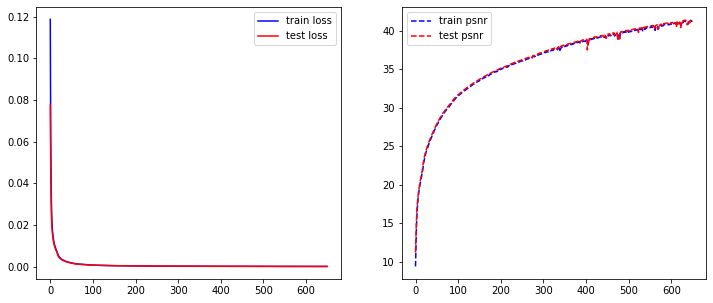

In [10]:
#plot loss & psnr

_, ax = plt.subplots(1,2)
ax[0].plot(hist_loss_train, label='train loss', c='b')
ax[0].plot(hist_loss_test, label='test loss', c='r')
ax[0].legend()
ax[1].plot(hist_psnr_train, label='train psnr', c='b', linestyle='--')
ax[1].plot(hist_psnr_test, label='test psnr', c='r', linestyle='--')
ax[1].legend()
_.set_size_inches(12,5)

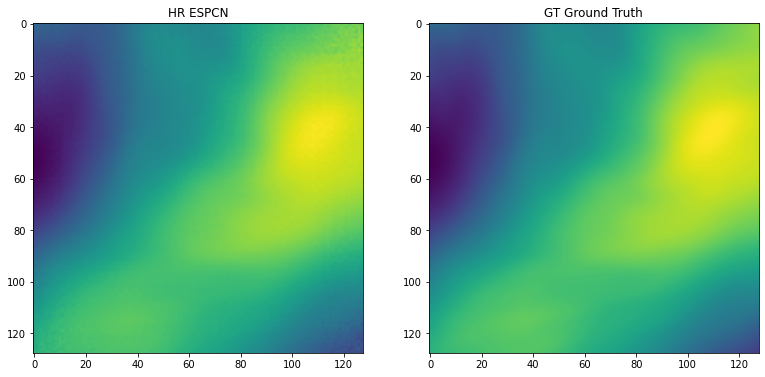

In [12]:
#plot example
tests, targets = next(iter(testloader))

GT = targets[0].squeeze()
HR = model(tests[0].float()).squeeze()

_, ax = plt.subplots(1,2)
ax[0].imshow(HR.detach().numpy())
ax[1].imshow(GT)
ax[0].title.set_text('HR ESPCN')
ax[1].title.set_text('GT Ground Truth')

_.set_size_inches(13,13)
plt.show()

In [13]:
#Errors

errors_L1 = []
error_L2 = 0

for i, (tests, targets) in enumerate(testloader):
  for idx in range(len(tests)):

    GT = targets[idx].squeeze().detach().numpy()
    HR = model(tests[idx].float()).squeeze().detach().numpy()
    
    errors_L1.append(np.abs((HR - GT) / GT))
    error_L2 += np.sqrt(((HR - GT)**2).sum() / (GT**2).sum())

errors_L1 = np.array(errors_L1)
error_L2 /= 56

Text(0.5, 0.98, 'relative L1 error')

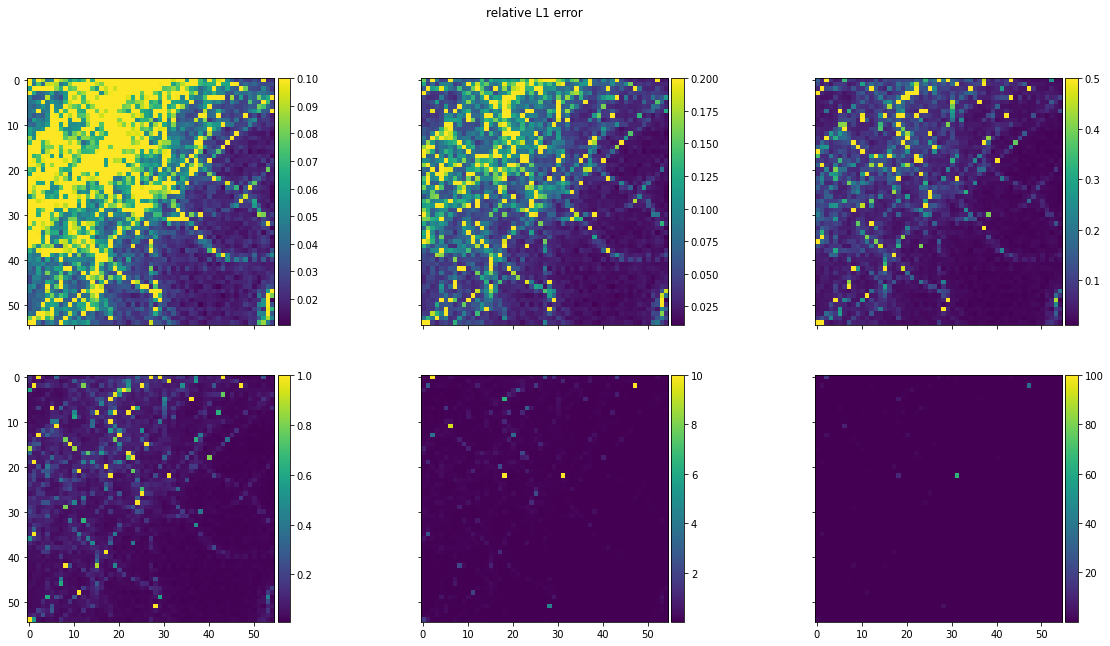

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,10))
MAX = [0.1, 0.2, 0.5, 1, 10, 100]

k=-1
im=[]
for i in range(2):
    for j in range(3):
        k += 1
        im.append(ax[i,j].imshow(errors_L1.mean(axis=0), vmax=MAX[k]))
        divider = make_axes_locatable(ax[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im[k], cax=cax, orientation='vertical')

plt.suptitle('relative L1 error')

In [47]:
error_L2

0.02329780827597597

In [48]:
w.abs().mean()

tensor(0.2723, dtype=torch.float64)